In [1]:
import catboost as cgb
from catboost import CatBoostClassifier
import lightgbm as lgb

import pandas as pd
import numpy as np
import time
import gc
import psutil
from joblib import Parallel, delayed

from sklearn.model_selection import KFold,StratifiedKFold,train_test_split
from sklearn.metrics import f1_score

from datetime import datetime,timedelta

import matplotlib.pyplot as plt
import seaborn as sns

import shap
shap.initjs()

feature_path = 'feature/'
model_path = 'model/'
submit_path = 'submit/'
#stacking feature data
metafeature_path = 'meta-feature/'
pic_path = 'pic/'
train_data_1_len = 1000000
train_data_2_len = 5000000
test_data_len = 1000000


def reduce_mem_usage(data):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = data.memory_usage().sum() / 1024**2    
    for col in data.columns:
        col_type = data[col].dtypes
        if col_type in numerics:
            c_min = data[col].min()
            c_max = data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    data[col] = data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    data[col] = data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    data[col] = data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    data[col] = data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    data[col] = data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    data[col] = data[col].astype(np.float32)
                else:
                    data[col] = data[col].astype(np.float64)    
    end_mem = data.memory_usage().sum() / 1024**2
    print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return data

def combine_feature_feather(feature_file_list=None):
    '''
    从feature文件夹中加载feature
    feature_file_list:默认加载feature_path下所有feature文件；可传入列表选择文件
    '''
    if feature_file_list != None and type(feature_file_list) != list:
        raise ValueError("Unable to load features from {0}".format(str(feature_file_list)))
    
    if feature_file_list == None:
        feature_file_list = os.listdir(feature_path)
    
    if len(feature_file_list) < 1:
        print('Empty feature file list')
        return None
    
    # 无法读取混合类型的文件
    # 请将feature_path目录下文件统一格式存储
    file_type_num = len(set([x.split('.') for x in feature_file_list]))
    if file_type_num > 1:
        raise ValueError("Unable to load features from mix type feature file : file type number-{0}".format(str(file_type_num)))
    
    #并行读取文件
    feature_df_list = []
    def df_append(file):
        feature_df_list.append(pd.read_feather(file))

    Parallel(n_jobs=-1)(delayed(df_append)(file_name) for file_name in feature_file_list)
    
    data = pd.concat(feature_df_list,axis=1).reset_index(drop=True)
    del feature_df_list
    gc.collect()
    return data


#计算F1score的函数,传入正确的结果和预测结果，返回F1_score
def cal_f1(true_valid,pred_valid):
    pred_valid = np.round(pred_valid)
    TP = np.sum(true_valid*pred_valid, axis=0)
    TN = np.sum((1-true_valid)*(1-(pred_valid)), axis=0)
    FP = np.sum((1-true_valid)*(pred_valid), axis=0)
    FN = np.sum(true_valid*(1-(pred_valid)), axis=0)
    
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1 = 2*precision*recall/(precision + recall)
    return F1

def lgb_f1(true_valid,pred_valid):
    return ('f1',cal_f1(true_valid,pred_valid),True)

def kfold_train(train_x,train_y,test,kfold=5):
    '''
    clf
    train_x:训练集特征，需去除sid和label
    train_y:训练集对应的label
    test:测试集特征，需去除sid和label(-1)
    '''
    f1s = []
    features = [col for col in train_x.columns if col not in ['sid', 'label']]
    train_pred = np.zeros(train_x.shape[0])
    test_pred = np.zeros(test.shape[0]) 
    skf=StratifiedKFold(n_splits=kfold,shuffle=True,random_state=2019)
    seed = [20190920,6666,1024,2048,4096]
    
    for i,(train_fold,valid_fold) in enumerate(skf.split(train_x,train_y)):
        print('====================fold {0}===================='.format(i+1))
        
        model = CatBoostClassifier(iterations=5000,learning_rate=0.15,max_depth=8,
                                       task_type='GPU',eval_metric='F1',
                                       cat_features=cat_list,use_best_model=True, early_stopping_rounds=200,
                                  boosting_type='Plain',max_bin=15,max_ctr_complexity=4)
        model.random_state = seed[i]
        print('training start')
        model.fit(pd.DataFrame(np.array(train_x)[train_fold],columns=features),
                  train_y[train_fold],
                  eval_set = (pd.DataFrame(np.array(train_x)[valid_fold],columns=features),
                              train_y[valid_fold]),verbose=100)
        
        print('training completed')
        gc.collect()
        #sklearn的概率预测有两列，对应0和1；取第二列
        train_pred[valid_fold] += model.predict_proba(pd.DataFrame(np.array(train_x)[valid_fold],columns=features))[:,1]
        print('valid predict completed')
        f1s.append(cal_f1(train_y[valid_fold],train_pred[valid_fold]))
        test_pred += model.predict_proba(test)[:,1]
        print('test predict completed')
        del model
        gc.collect()

    print('oof f1:',cal_f1(np.round(train_pred),train_y))
    print('oof mean f1:',np.mean(f1s))
    print('oof f1 std:',np.std(f1s))
    test_pred/=5
    return train_pred,test_pred

def cgb_train_once(model,train_x,train_y):
    features = [col for col in train_x.columns if col not in ['sid', 'label']] 
    seed = 20190920
    model.random_state = seed
    X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.1, random_state=seed,shuffle=True)
                                      
    
    
    model.fit(pd.DataFrame(X_train,columns=features),y_train,
                  eval_set = (pd.DataFrame(X_test,columns=features),y_test),verbose=50)
    
    
    return True

def show_mem():
    mem = psutil.virtual_memory()
    
    total = str(round(mem.total / 1024 / 1024))
    used = str(round(mem.used / 1024 / 1024))
    use_per = str(round(mem.percent))
    free = str(round(mem.free / 1024 / 1024))
    
    print("total mem:" + total + "M")
    print("mem usage:" + used + "M(" + use_per + "%)")
    print("mem available:" + free + "M")

In [2]:
%time data = pd.read_feather(feature_path+'combine_gragh.bin')
#data.drop([col+'_UID_nunique_mean' for col in ['make','pkgname','adunitshowid','ver','osv','apptype','mediashowid']],axis=1,inplace=True)
%time data = reduce_mem_usage(data)

train_x = data[1000000:6000000]
train_y=train_x['label'].values
test=data[6000000:].reset_index(drop=True)
del data
gc.collect()

Wall time: 4.2 s
Mem. usage decreased to 6233.22 Mb (4.2% reduction)
Wall time: 6.7 s


7

In [3]:
train_x['label'] = train_x['label'].astype(int)

In [16]:
[col for col in train_x.columns if str(train_x.dtypes[col])[0] == 'f']

['h', 'w', 'empty_count', 'h_w_ratio', 'size', 'px']

In [11]:
train_x.columns[:75]

Index(['sid', 'label', 'pkgname', 'ver', 'adunitshowid', 'mediashowid',
       'apptype', 'ip', 'province', 'reqrealip', 'adidmd5', 'imeimd5',
       'macmd5', 'dvctype', 'model', 'make', 'ntt', 'carrier', 'osv', 'lan',
       'h', 'w', 'empty_count', 'ip3', 'osv_summary', 'h_w_ratio', 'size',
       'px', 'creative_dpi', 'device_info', 'make&model', 'make&creative_dpi',
       'make&mediashowid', 'make&adunitshowid', 'make&pkgname', 'make&ver',
       'make&osv', 'make&apptype', 'make&device_info', 'model&creative_dpi',
       'model&mediashowid', 'model&adunitshowid', 'model&pkgname', 'model&ver',
       'model&osv', 'model&apptype', 'model&device_info',
       'creative_dpi&mediashowid', 'creative_dpi&adunitshowid',
       'creative_dpi&pkgname', 'creative_dpi&ver', 'creative_dpi&osv',
       'creative_dpi&apptype', 'creative_dpi&device_info',
       'mediashowid&adunitshowid', 'mediashowid&pkgname', 'mediashowid&ver',
       'mediashowid&osv', 'mediashowid&apptype', 'mediashowid&de

In [4]:
#删掉了种数多的
useless_ft = ['reqrealip','ip','adidmd5','macmd5','imeimd5','lan','make&model']
cat_list = [col for col in train_x.columns if col not in ['sid','label','h','w','ppi','empty_count','h_w_ratio', 'size','px','screen_area']+useless_ft]

In [19]:
cat_list

['pkgname',
 'ver',
 'adunitshowid',
 'mediashowid',
 'apptype',
 'province',
 'dvctype',
 'model',
 'make',
 'ntt',
 'carrier',
 'osv',
 'ip3',
 'osv_summary',
 'creative_dpi',
 'device_info',
 'make&creative_dpi',
 'make&mediashowid',
 'make&adunitshowid',
 'make&pkgname',
 'make&ver',
 'make&osv',
 'make&apptype',
 'make&device_info',
 'model&creative_dpi',
 'model&mediashowid',
 'model&adunitshowid',
 'model&pkgname',
 'model&ver',
 'model&osv',
 'model&apptype',
 'model&device_info',
 'creative_dpi&mediashowid',
 'creative_dpi&adunitshowid',
 'creative_dpi&pkgname',
 'creative_dpi&ver',
 'creative_dpi&osv',
 'creative_dpi&apptype',
 'creative_dpi&device_info',
 'mediashowid&adunitshowid',
 'mediashowid&pkgname',
 'mediashowid&ver',
 'mediashowid&osv',
 'mediashowid&apptype',
 'mediashowid&device_info',
 'adunitshowid&pkgname',
 'adunitshowid&ver',
 'adunitshowid&osv',
 'adunitshowid&apptype',
 'adunitshowid&device_info',
 'pkgname&ver',
 'pkgname&osv',
 'pkgname&apptype',
 'pkgname&device_info',
 'ver&osv',
 'ver&apptype',
 'ver&device_info',
 'osv&apptype',
 'osv&device_info',
 'apptype&device_info',
 'make&creative_dpi&mediashowid&pkgname',
 'make&creative_dpi&mediashowid&ver',
 'make&creative_dpi&mediashowid&osv',
 'make&creative_dpi&mediashowid&apptype',
 'make&creative_dpi&mediashowid&device_info',
 'make&creative_dpi&adunitshowid&pkgname',
 'make&creative_dpi&adunitshowid&ver',
 'make&creative_dpi&adunitshowid&osv',
 'make&creative_dpi&adunitshowid&apptype',
 'make&creative_dpi&adunitshowid&device_info',
 'make&creative_dpi&pkgname&ver',
 'make&creative_dpi&pkgname&osv',
 'make&creative_dpi&pkgname&apptype',
 'make&creative_dpi&pkgname&device_info',
 'make&creative_dpi&ver&osv',
 'make&creative_dpi&ver&apptype',
 'make&creative_dpi&ver&device_info',
 'make&creative_dpi&osv&apptype',
 'make&creative_dpi&osv&device_info',
 'make&creative_dpi&apptype&device_info',
 'make&mediashowid&pkgname&ver',
 'make&mediashowid&pkgname&osv',
 'make&mediashowid&pkgname&apptype',
 'make&mediashowid&pkgname&device_info',
 'make&mediashowid&ver&osv',
 'make&mediashowid&ver&apptype',
 'make&mediashowid&ver&device_info',
 'make&mediashowid&osv&apptype',
 'make&mediashowid&osv&device_info',
 'make&mediashowid&apptype&device_info',
 'make&adunitshowid&pkgname&ver',
 'make&adunitshowid&pkgname&osv',
 'make&adunitshowid&pkgname&apptype',
 'make&adunitshowid&pkgname&device_info',
 'make&adunitshowid&ver&osv',
 'make&adunitshowid&ver&apptype',
 'make&adunitshowid&ver&device_info',
 'make&adunitshowid&osv&apptype',
 'make&adunitshowid&osv&device_info',
 'make&adunitshowid&apptype&device_info',
 'make&pkgname&ver&osv',
 'make&pkgname&ver&apptype',
 'make&pkgname&ver&device_info',
 'make&pkgname&osv&apptype',
 'make&pkgname&osv&device_info',
 'make&pkgname&apptype&device_info',
 'make&ver&osv&apptype',
 'make&ver&osv&device_info',
 'make&ver&apptype&device_info',
 'make&osv&apptype&device_info',
 'model&creative_dpi&mediashowid&pkgname',
 'model&creative_dpi&mediashowid&ver',
 'model&creative_dpi&mediashowid&osv',
 'model&creative_dpi&mediashowid&apptype',
 'model&creative_dpi&mediashowid&device_info',
 'model&creative_dpi&adunitshowid&pkgname',
 'model&creative_dpi&adunitshowid&ver',
 'model&creative_dpi&adunitshowid&osv',
 'model&creative_dpi&adunitshowid&apptype',
 'model&creative_dpi&adunitshowid&device_info',
 'model&creative_dpi&pkgname&ver',
 'model&creative_dpi&pkgname&osv',
 'model&creative_dpi&pkgname&apptype',
 'model&creative_dpi&pkgname&device_info',
 'model&creative_dpi&ver&osv',
 'model&creative_dpi&ver&apptype',
 'model&creative_dpi&ver&device_info',
 'model&creative_dpi&osv&apptype',
 'model&creative_dpi&osv&device_info',
 'model&creative_dpi&apptype&device_info',
 'model&mediashowid&pkgname&ver',
 'model&mediashowid&pkgname&osv',
 'model&mediashowid&pkgname&apptype',
 'model&mediashowid&pkgname&device_info',
 'model&mediashowid&ver&osv',
 'model&mediashowid&ver&apptype',
 'model&mediashowid&ver&device_info',
 'model&mediashowid&

In [ ]:
cat_list = ['pkgname', 'ver', 'adunitshowid', 'mediashowid',
       'apptype', 'ip', 'city',  'reqrealip', 'adidmd5', 'imeimd5',
      'macmd5',  'model', 'make', 
        'osv',  'lan', 
        'ip1', 'ip2', 'ip3', 'reqrealip1', 'reqrealip2',
       'reqrealip3',  'osv_summary', 
        'big_model', 
      'creative_dpi', 'pkgname&ver',
       'pkgname&ver&apptype','pkgname&ver&apptype&osv&lan',
        'adunitshowid&reqrealip',
       'adunitshowid&reqrealip&pkgname', 'adunitshowid&reqrealip&pkgname&ver',
       'adunitshowid&reqrealip&pkgname&ver&apptype']
num_list = [col for col in train_x.columns if col not in cat_list + ['sid','label']]
useless_ft = ['ip_equal','orientation','province',
              'nginxtime-begin_time','ppi','minute',
             'period','hour','idfamd5', 'openudidmd5','os','new_ntt','ntt','dvctype','carrier','model_equal_make', 'pkgname&ver&apptype&osv']

In [5]:
cgb_model = CatBoostClassifier(iterations=5000,learning_rate=0.2,max_depth=8,
                                       task_type='GPU',eval_metric='F1',
                                       cat_features=cat_list,use_best_model=True, early_stopping_rounds=100,
                                  boosting_type='Plain',max_bin=15,max_ctr_complexity=1,gpu_cat_features_storage='CpuPinnedMemory')

In [ ]:
%time _,test_pred = kfold_train(train_x.drop(['sid','label']+useless_ft,axis=1),train_y,test.drop(['sid','label']+useless_ft,axis=1))

====================fold 1====================
training start
0:	learn: 0.9665503	test: 0.9702268	best: 0.9702268 (0)	total: 4.08s	remaining: 5h 39m 42s
100:	learn: 0.9765373	test: 0.9784410	best: 0.9784518 (99)	total: 5m 41s	remaining: 4h 36m 24s
200:	learn: 0.9772070	test: 0.9788373	best: 0.9788373 (200)	total: 11m 15s	remaining: 4h 28m 58s
300:	learn: 0.9775651	test: 0.9789863	best: 0.9789940 (297)	total: 16m 52s	remaining: 4h 23m 29s
400:	learn: 0.9778503	test: 0.9791029	best: 0.9791029 (400)	total: 22m 30s	remaining: 4h 18m 5s
500:	learn: 0.9780791	test: 0.9791834	best: 0.9791834 (500)	total: 27m 59s	remaining: 4h 11m 18s
600:	learn: 0.9782888	test: 0.9792372	best: 0.9792503 (591)	total: 33m 39s	remaining: 4h 6m 20s
700:	learn: 0.9784897	test: 0.9792579	best: 0.9792807 (693)	total: 39m 24s	remaining: 4h 1m 41s
800:	learn: 0.9786515	test: 0.9793176	best: 0.9793176 (800)	total: 44m 58s	remaining: 3h 55m 48s
900:	learn: 0.9788298	test: 0.9793734	best: 0.9793749 (890)	total: 50m 37s	r

In [ ]:
(1355+1893+1383+1099+1322)/5

In [ ]:
%time cgb_train_once(cgb_model,train_x.drop(['sid','label']+useless_ft,axis=1),train_y)

In [ ]:
features = [col for col in train_x.columns if col not in ['sid', 'label']+useless_ft]
seed = 20190920
cgb_model.random_state = seed
%time X_train, X_test, y_train, y_test = train_test_split(train_x.drop(['sid','label']+useless_ft,axis=1), train_y, test_size=0.1, random_state=seed,shuffle=True)

%time cgb_model.fit(pd.DataFrame(X_train,columns=features),y_train,eval_set = (pd.DataFrame(X_test,columns=features),y_test),verbose=50)

Wall time: 13.4 s


In [6]:
features = [col for col in train_x.columns if col not in ['sid', 'label']+useless_ft]
%time shap_values = cgb_model.get_feature_importance(data=cgb.Pool(X_test[:100000],cat_features=cat_list,feature_names=features),type='ShapValues',prettified=False,thread_count=-1,verbose=False)

Wall time: 51.3 s


In [7]:
features

['pkgname',
 'ver',
 'adunitshowid',
 'mediashowid',
 'apptype',
 'ip',
 'province',
 'reqrealip',
 'adidmd5',
 'imeimd5',
 'macmd5',
 'dvctype',
 'model',
 'make',
 'ntt',
 'carrier',
 'osv',
 'lan',
 'h',
 'w',
 'empty_count',
 'ip3',
 'osv_summary',
 'h_w_ratio',
 'screen_area',
 'size',
 'px',
 'creative_dpi',
 'device_info',
 'make&model',
 'make&creative_dpi',
 'make&mediashowid',
 'make&adunitshowid',
 'make&pkgname',
 'make&ver',
 'make&osv',
 'make&apptype',
 'make&device_info',
 'model&creative_dpi',
 'model&mediashowid',
 'model&adunitshowid',
 'model&pkgname',
 'model&ver',
 'model&osv',
 'model&apptype',
 'model&device_info',
 'creative_dpi&mediashowid',
 'creative_dpi&adunitshowid',
 'creative_dpi&pkgname',
 'creative_dpi&ver',
 'creative_dpi&osv',
 'creative_dpi&apptype',
 'creative_dpi&device_info',
 'mediashowid&adunitshowid',
 'mediashowid&pkgname',
 'mediashowid&ver',
 'mediashowid&osv',
 'mediashowid&apptype',
 'mediashowid&device_info',
 'adunitshowid&pkgname',
 'adunitshowid&ver',
 'adunitshowid&osv',
 'adunitshowid&apptype',
 'adunitshowid&device_info',
 'pkgname&ver',
 'pkgname&osv',
 'pkgname&apptype',
 'pkgname&device_info',
 'ver&osv',
 'ver&apptype',
 'ver&device_info',
 'osv&apptype',
 'osv&device_info',
 'apptype&device_info',
 'ip_count',
 'ip3_count',
 'reqrealip_count',
 'imeimd5_count',
 'macmd5_count',
 'adidmd5_count',
 'make&model_count',
 'make&creative_dpi_count',
 'make&mediashowid_count',
 'make&adunitshowid_count',
 'make&pkgname_count',
 'make&ver_count',
 'make&osv_count',
 'make&apptype_count',
 'make&device_info_count',
 'model&creative_dpi_count',
 'model&mediashowid_count',
 'model&adunitshowid_count',
 'model&pkgname_count',
 'model&ver_count',
 'model&osv_count',
 'model&apptype_count',
 'model&device_info_count',
 'creative_dpi&mediashowid_count',
 'creative_dpi&adunitshowid_count',
 'creative_dpi&pkgname_count',
 'creative_dpi&ver_count',
 'creative_dpi&osv_count',
 'creative_dpi&apptype_count',
 'creative_dpi&device_info_count',
 'mediashowid&adunitshowid_count',
 'mediashowid&pkgname_count',
 'mediashowid&ver_count',
 'mediashowid&osv_count',
 'mediashowid&apptype_count',
 'mediashowid&device_info_count',
 'adunitshowid&pkgname_count',
 'adunitshowid&ver_count',
 'adunitshowid&osv_count',
 'adunitshowid&apptype_count',
 'adunitshowid&device_info_count',
 'pkgname&ver_count',
 'pkgname&osv_count',
 'pkgname&apptype_count',
 'pkgname&device_info_count',
 'ver&osv_count',
 'ver&apptype_count',
 'ver&device_info_count',
 'osv&apptype_count',
 'osv&device_info_count',
 'apptype&device_info_count']

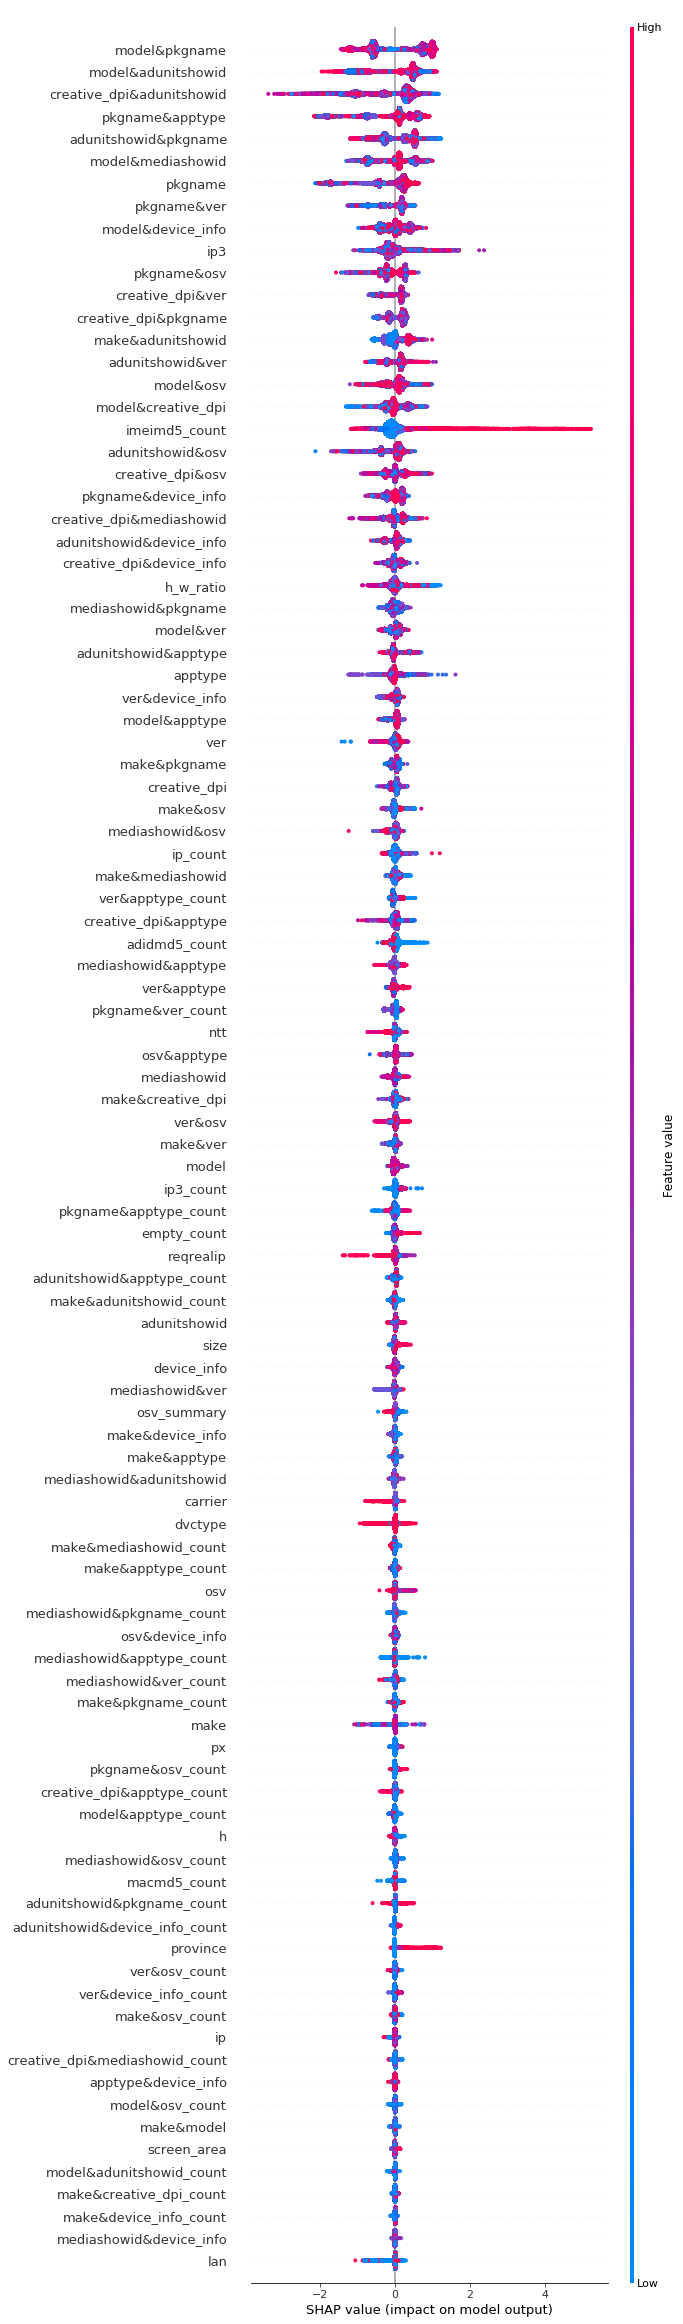

Wall time: 2min 35s


In [8]:
%time shap.summary_plot(shap_values[:,:-1], pd.DataFrame(X_test[:100000],columns=features),max_display=100)

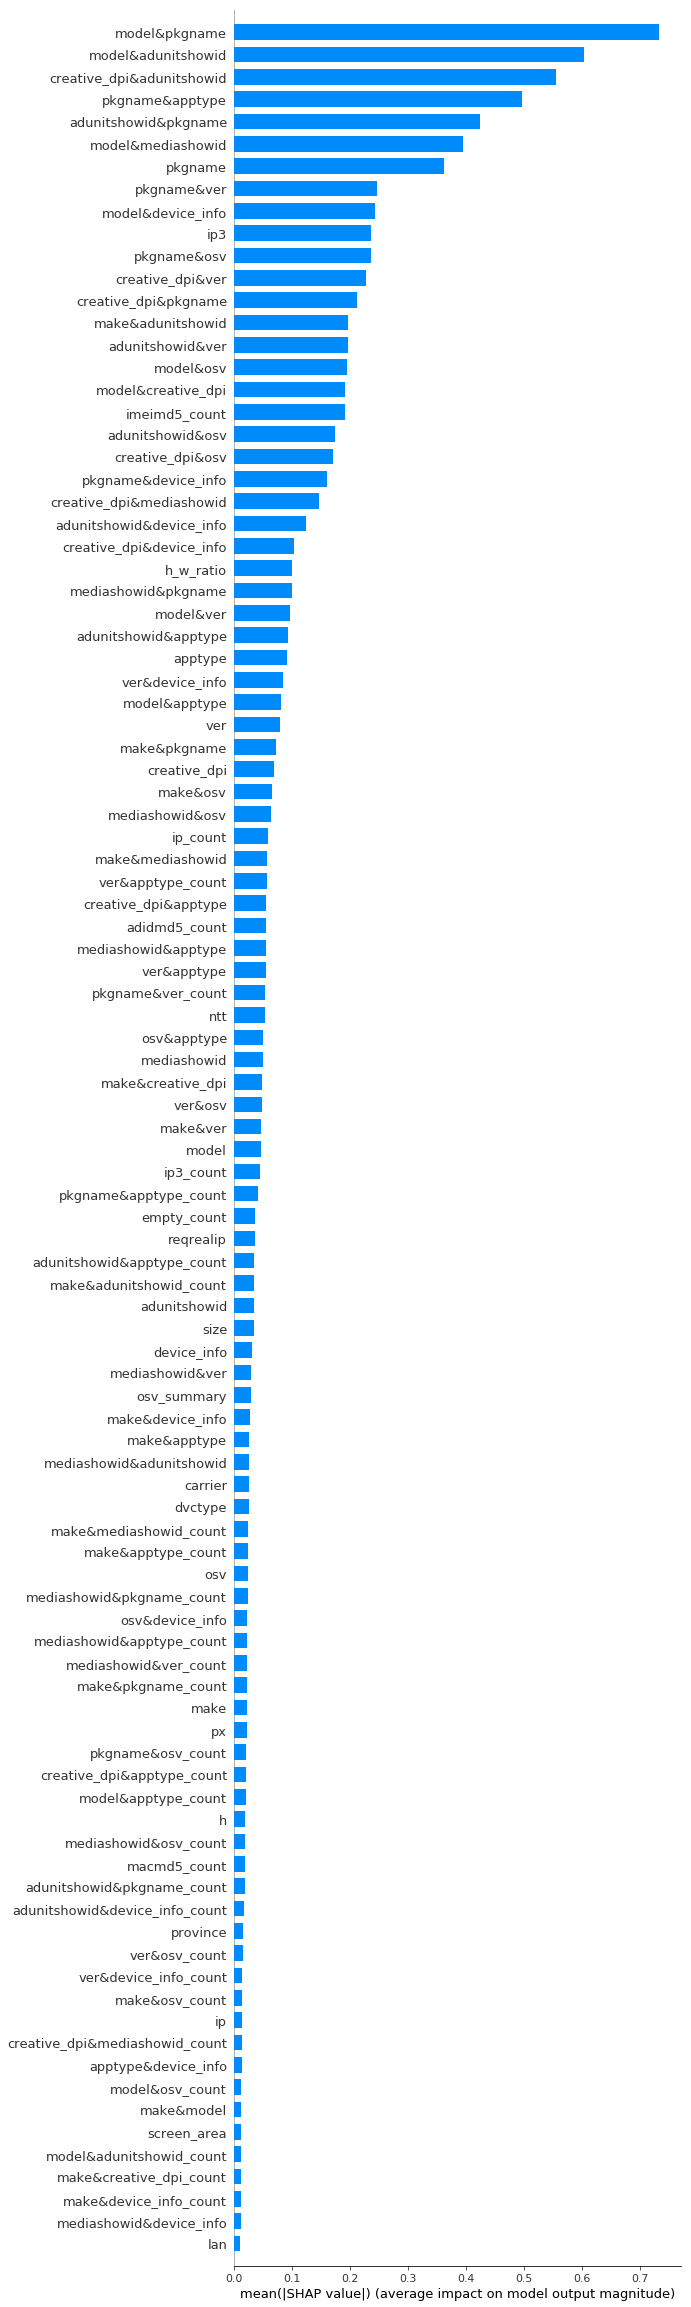

Wall time: 1.38 s


In [9]:
%time shap.summary_plot(shap_values[:,:-1], pd.DataFrame(X_test[:100000],columns=features),max_display=100, plot_type="bar")

In [10]:
%time feature_score = cgb_model.get_feature_importance(data=cgb.Pool(X_test[:100000],cat_features=cat_list,feature_names=features),type='FeatureImportance',prettified=True,thread_count=-1,verbose=False)

Wall time: 8.65 s


In [17]:
cgb_model.plot_tree(tree_idx=1,pool=cgb.Pool(X_test[:100000],cat_features=cat_list,feature_names=features))

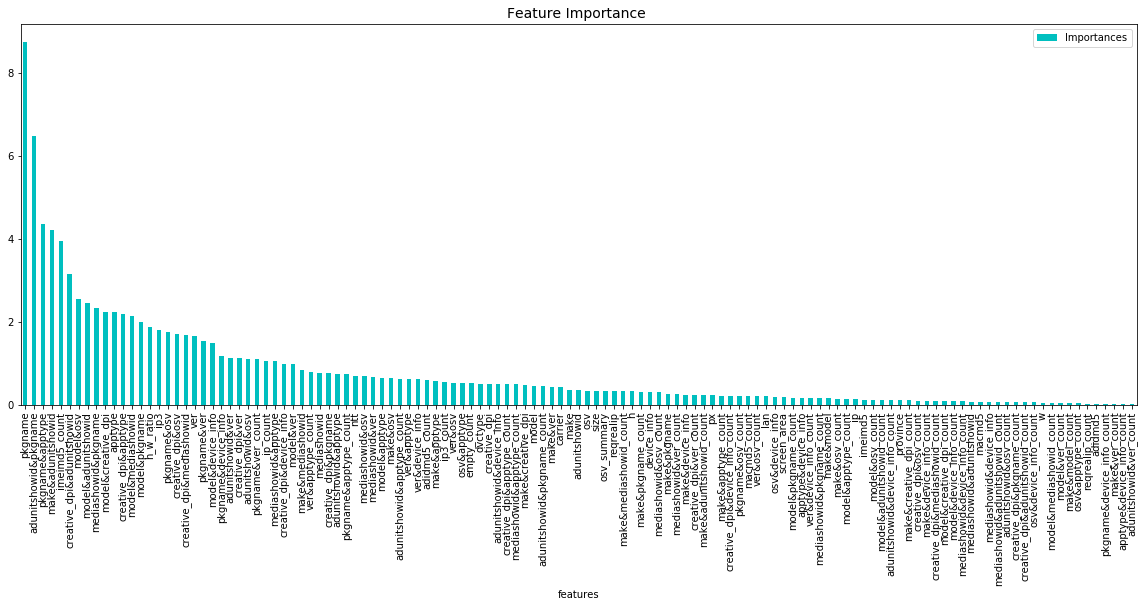

In [13]:
plt.rcParams["figure.figsize"] = (20,7)
ax = feature_score.plot('Feature Id','Importances',  kind='bar', color='c')
ax.set_title("Feature Importance ", fontsize = 14)
ax.set_xlabel("features")
plt.show()

In [14]:
%time interact = cgb_model.get_feature_importance(data=cgb.Pool(X_test[:100000],cat_features=cat_list,feature_names=features),type='Interaction',prettified=True,thread_count=-1,verbose=False)

Wall time: 8.37 s


In [15]:
for i,ft in enumerate(features):
    interact['First Feature Index'][interact['First Feature Index']==i] = ft
    interact['Second Feature Index'][interact['Second Feature Index']==i] = ft
interact['Feature Index'] = interact['First Feature Index']+'_with_'+interact['Second Feature Index']
interact = interact.drop(['First Feature Index','Second Feature Index'],axis=1)

G:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
G:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


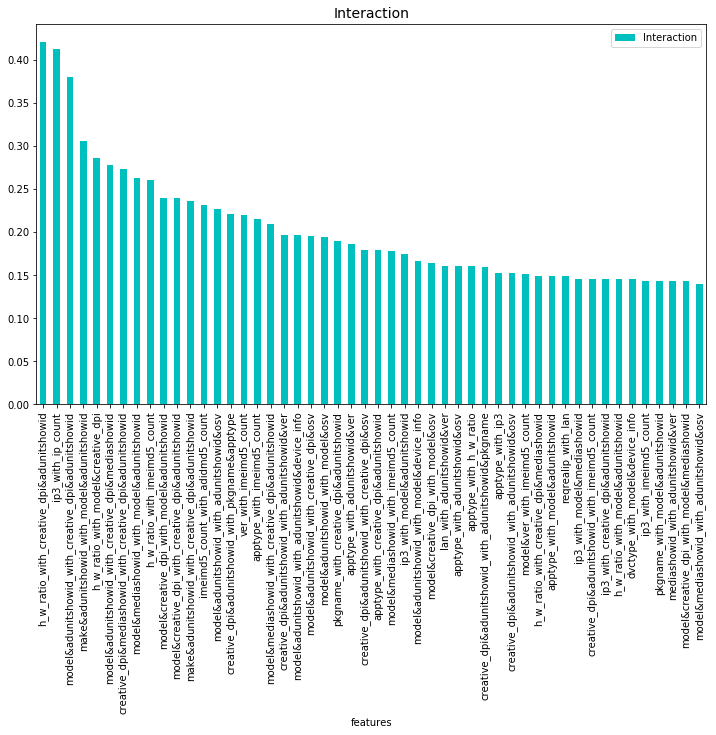

In [16]:
plt.rcParams["figure.figsize"] = (12,7)
ax = interact[:50].plot('Feature Index', 'Interaction', kind='bar', color='c')
ax.set_title("Interaction", fontsize = 14)
ax.set_xlabel("features")
plt.show()

In [ ]:
result_df = pd.DataFrame() 
result_df['sid'] = test['sid'].tolist()
result_df['label'] = test_pred
result_df['label'] = np.round(result_df['label'])
lct = time.localtime()
result_df.to_csv(submit_path+'submit_{0}-{1}-{2}-{3}-{4}.csv'.format(lct.tm_year,lct.tm_mon,lct.tm_mday,lct.tm_hour,lct.tm_min),index=None)
result_df['label'].value_counts()